<a href="https://colab.research.google.com/github/GarrettTChrisman/MA489_AY23-2/blob/main/Main_V2_5.1_cleaned.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### AUTH

In [1]:
# Cloud authentication.
from google.colab import auth
auth.authenticate_user()

In [ ]:
# Import, authenticate and initialize the Earth Engine library.
import ee
ee.Authenticate()
ee.Initialize()

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://code.earthengine.google.com/client-auth?scopes=https%3A//www.googleapis.com/auth/earthengine%20https%3A//www.googleapis.com/auth/devstorage.full_control&request_id=pVz4t2n4iz8vc0Qs0YICcPy5-ibQfGTf82muX9hK8TQ&tc=_nasUVl481OOo1xS7UV5r5z9sHiQG0FuLexIBmUcE-g&cc=7U8cMd9tS4ub4EbQNDe0VUjOPUf1C_W3JNAHFvlFdAk

The authorization workflow will generate a code, which you should paste in the box below.


In [3]:
# Folium setup.
import folium
print(folium.__version__)

0.14.0


Section 1: Import Libraries and Define Parameters

### **Geometries**

In [4]:
import ee
import folium
from IPython.display import HTML

# Initialize the Earth Engine API
ee.Initialize()

# Define the study area

geometryPINEGULCH = ee.Geometry.Polygon(
        [[[-108.80164742558028, 39.28402267340665],
          [-108.23722481815841, 39.29358857295844],
          [-108.23997140018966, 39.56831366828538],
          [-108.79752755253341, 39.553491364366145]
          ]])

geometryGRIZZLYCREEK = ee.Geometry.Polygon(
        [[[-107.40066503796388, 39.69746161256133],
          [-107.39860510144044, 39.46619798632684],
          [-106.90834020886231, 39.46778823854969],
          [-106.96670507702638, 39.74763415825682],
          [-107.40272497448731, 39.73337830588799]
          ]])

geometryCHERRYCANYON = ee.Geometry.Polygon(
        [[[-103.53011965523325, 37.51499254964799],
          [-103.53011965523325, 37.336135915833296],
          [-103.33785891304575, 37.33176822282621],
          [-103.33785891304575, 37.519349567331446]]]);

#CRONAN fire 2021-07-31 CA 7,600 acres
#Lake CHRISTINE 2018-07-03 CO 12,500 acres
#Bull DRAW 2018-07-29 CO 30,000 Acres

geometries_dict = {
    'PineGulch': geometryPINEGULCH,
    'GrizzlyCreek': geometryGRIZZLYCREEK,
    'CherryCanyon': geometryCHERRYCANYON,
}

geometries = [geometryPINEGULCH, geometryGRIZZLYCREEK, geometryCHERRYCANYON]

#geometryCANADA1.getInfo()

In [5]:
def get_fire_boundary(event_id):
    dataset = ee.FeatureCollection('USFS/GTAC/MTBS/burned_area_boundaries/v1')
    filtered_dataset = dataset.filter(ee.Filter.eq('Event_ID', event_id))

    if filtered_dataset.size().getInfo() > 0:
        selected_fire = ee.Feature(filtered_dataset.first())
        fire_geometry = selected_fire.geometry()
        geometry_type = fire_geometry.type().getInfo()

        if geometry_type == 'Polygon':
            coordinates = fire_geometry.coordinates().getInfo()
            fire_polygon = ee.Geometry.Polygon(coordinates)
            return fire_polygon
        elif geometry_type == 'GeometryCollection':
            geometries = fire_geometry.geometries().getInfo()
            fire_multipolygon = ee.Geometry.MultiPolygon(geometries)
            return fire_multipolygon
        else:
            print(f"Unsupported geometry type: {geometry_type}")
            return None
    else:
        print(f"No features found with the specified Event_ID: {event_id}")
        return None


event_id_PineGulch = 'CO3933610852620200731'
event_id_GrizzlyCreek = 'CO3957210726620200810'
event_id_CherryCanyon = 'CO3736710345020200520'

event_id_dict = {
    'PineGulch': 'CO3933610852620200731',
    'GrizzlyCreek': 'CO3957210726620200810',
    'CherryCanyon':'CO3736710345020200520',

}

fire_boundaries = {}

#for fire_name, event_id in event_id_dict.items():
#    fire_boundary = get_fire_boundary(event_id)
#
#    if fire_boundary is not None:
#        fire_boundaries[fire_name] = fire_boundary
#        print(f"Added fire boundary for {fire_name} to the fire_boundaries dictionary:")
#        print(fire_boundaries[fire_name].getInfo())

for fire_name, polygon in geometries_dict.items():
    #fire_boundary = get_fire_boundary(polygon)

    if polygon is not None:
        fire_boundaries[fire_name] = polygon
        print(f"Added fire boundary for {fire_name} to the fire_boundaries dictionary:")
        print(fire_boundaries[fire_name].getInfo())

Added fire boundary for PineGulch to the fire_boundaries dictionary:
{'type': 'Polygon', 'coordinates': [[[-108.80164742558028, 39.28402267340665], [-108.23722481815841, 39.29358857295844], [-108.23997140018966, 39.56831366828538], [-108.79752755253341, 39.553491364366145], [-108.80164742558028, 39.28402267340665]]]}
Added fire boundary for GrizzlyCreek to the fire_boundaries dictionary:
{'type': 'Polygon', 'coordinates': [[[-107.40066503796388, 39.69746161256133], [-107.39860510144044, 39.46619798632684], [-106.90834020886231, 39.46778823854969], [-106.96670507702638, 39.74763415825682], [-107.40272497448731, 39.73337830588799], [-107.40066503796388, 39.69746161256133]]]}
Added fire boundary for CherryCanyon to the fire_boundaries dictionary:
{'type': 'Polygon', 'coordinates': [[[-103.53011965523325, 37.51499254964799], [-103.53011965523325, 37.336135915833296], [-103.33785891304575, 37.33176822282621], [-103.33785891304575, 37.519349567331446], [-103.53011965523325, 37.51499254964799

Section 2: Define Functions, Load Images, and Create Maps

### **DATES**

In [6]:
fire_dates = {
    'PineGulch': {
        'prefire_start': '2020-05-20',
        'prefire_end': '2020-06-18',
        'postfire_start': '2020-09-20',
        'postfire_end': '2020-10-28'
    },

    'GrizzlyCreek': {
        'prefire_start': '2020-05-20',
        'prefire_end': '2020-07-18',
        'postfire_start': '2020-09-06',
        'postfire_end': '2020-11-01'
    },

    'CherryCanyon':{
         'prefire_start': '2020-04-20',
        'prefire_end': '2020-05-15',
        'postfire_start': '2020-07-01',
        'postfire_end': '2020-08-15'
    }
}


### **Sentinel 2**

In [7]:
def maskS2sr(image):
    cloudBitMask = ee.Number(2).pow(10).int()
    cirrusBitMask = ee.Number(2).pow(11).int()
    qa = image.select('QA60')
    mask = qa.bitwiseAnd(cloudBitMask).eq(0).And(qa.bitwiseAnd(cirrusBitMask).eq(0))
    return image.updateMask(mask).copyProperties(image, ["system:time_start"])

def create_rgb_image(image, geometry, viz_params={'bands': ['B4', 'B3', 'B2'], 'min': 0, 'max': 3000}):
    """Creates RGB image from the given image and geometry."""
    return image.clip(geometry).visualize(**viz_params)


def calculate_dnbr_and_classification(prefire_start, prefire_end, postfire_start, postfire_end, geometry):
    #geometry1 = geometryEASTTROUBLESOME

    prefire_collection_S2 = (ee.ImageCollection('COPERNICUS/S2_SR').filterBounds(geometry).filterDate(prefire_start, prefire_end).map(maskS2sr).median())

    postfire_collection_S2 = (ee.ImageCollection('COPERNICUS/S2_SR').filterBounds(geometry).filterDate(postfire_start, postfire_end).map(maskS2sr).median())

    rgb_prefire_image = create_rgb_image(prefire_collection_S2, geometry)
    rgb_postfire_image = create_rgb_image(postfire_collection_S2, geometry)

    prefire_NBR_S2 = prefire_collection_S2.normalizedDifference(['B8', 'B12'])
    postfire_NBR_S2 = postfire_collection_S2.normalizedDifference(['B8', 'B12'])
    dNBR_unscaled_S2 = prefire_NBR_S2.subtract(postfire_NBR_S2)
    dNBR_S2 = dNBR_unscaled_S2.multiply(1000)

    thresholds_S2 = ee.Image([-1000, -251, -101, 99, 269, 439, 659, 2000])
    classified_S2 = dNBR_S2.lt(thresholds_S2).reduce('sum').toInt()

    return dNBR_S2, classified_S2, prefire_collection_S2, rgb_prefire_image, rgb_postfire_image


dnbr_layers = {}
classification_layers = {}
dnbr_and_classification_results = {}

#for fire_name, fire_boundary in fire_boundaries.items():
#    dates = fire_dates[fire_name]
#    prefire_start = dates["prefire_start"]
#    prefire_end = dates["prefire_end"]
#    postfire_start = dates["postfire_start"]
#    postfire_end = dates["postfire_end"]#
#
#    dnbr, classification, postfire_NBR_S2 = calculate_dnbr_and_classification(
#        prefire_start, prefire_end, postfire_start, postfire_end, fire_boundary
#    )#
#
#    dnbr_and_classification_results[fire_name] = {"dnbr": dnbr, "classification": classification, "NBR": postfire_NBR_S2}

for fire_name, polygon in geometries_dict.items():
    dates = fire_dates[fire_name]
    prefire_start = dates["prefire_start"]
    prefire_end = dates["prefire_end"]
    postfire_start = dates["postfire_start"]
    postfire_end = dates["postfire_end"]

    dnbr, classification, postfire_NBR_S2, rgb_prefire_image, rgb_postfire_image = calculate_dnbr_and_classification(
        prefire_start, prefire_end, postfire_start, postfire_end, polygon
    )

    dnbr_and_classification_results[fire_name] = {
        "dnbr": dnbr,
        "classification": classification,
        "NBR": postfire_NBR_S2,
        "rgb_prefire_image": rgb_prefire_image,
        "rgb_postfire_image": rgb_postfire_image
    }

# You can access the dNBR and classification results:
#print(dnbr_and_classification_results["SpringCreek"]["dnbr"].getInfo())
#print(dnbr_and_classification_results["SpringCreek"]["classification"].getInfo())

#prefire_collection_S2 = ee.ImageCollection('COPERNICUS/S2_SR').filterBounds(fire_boundaries['SpringCreek']).filterDate('2018-05-05', '2018-06-26').map(maskS2sr)
#postfire_collection_S2 = ee.ImageCollection('COPERNICUS/S2_SR').filterBounds(fire_boundaries['SpringCreek']).filterDate('2018-09-15', '2018-10-29').map(maskS2sr)

#print("Number of prefire images:", prefire_collection_S2.size().getInfo())
#print("Number of postfire images:", postfire_collection_S2.size().getInfo())#

In [8]:
sld_intervals = ('<RasterSymbolizer>' +
'<ColorMap type="intervals" extended="false" >' +
'<ColorMapEntry color="#ffffff" quantity="-500" label="-500"/>' +
'<ColorMapEntry color="#7a8737" quantity="-250" label="-250" />' +
'<ColorMapEntry color="#acbe4d" quantity="-100" label="-100" />' +
'<ColorMapEntry color="#0ae042" quantity="100" label="100" />' +
'<ColorMapEntry color="#fff70b" quantity="270" label="270" />' +
'<ColorMapEntry color="#ffaf38" quantity="440" label="440" />' +
'<ColorMapEntry color="#ff641b" quantity="660" label="660" />' +
'<ColorMapEntry color="#a41fd6" quantity="2000" label="2000" />' +
'</ColorMap>' +
'</RasterSymbolizer>')


fire_name_s2 = 'PineGulch'
dnbr_to_display = dnbr_and_classification_results[fire_name_s2]["dnbr"]
classification_to_display = dnbr_and_classification_results[fire_name_s2]["classification"]
nbr = dnbr_and_classification_results[fire_name_s2]["NBR"]

map_dNBR_S2 = folium.Map(location=[39.40, -108.5], zoom_start=4)
map_class_S2 = folium.Map(location=[39.40, -108.5], zoom_start=4)

folium.TileLayer(tiles=dnbr_to_display.getMapId()['tile_fetcher'].url_format, attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>', overlay=True, name='dNBR').add_to(map_dNBR_S2)
folium.TileLayer(tiles=dnbr_to_display.sldStyle(sld_intervals).getMapId()['tile_fetcher'].url_format, attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>', overlay=True, name='dNBR classified').add_to(map_class_S2)
#folium.TileLayer(tiles=nbr.getMapId()['tile_fetcher'].url_format, attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>', overlay=True, name='dNBR').add_to(map_dNBR_S2)

html_dNBR_S2 = map_dNBR_S2._repr_html_()
html_class_S2 = map_class_S2._repr_html_()

# Combine the HTML codes into a single string
html_combined_S2 = f'<table><tr><td>{html_dNBR_S2}</td><td>{html_class_S2}</td></tr></table>'

# Display the maps using the combined HTML
HTML(html_combined_S2)

Section 3: Display Maps and Create dNBR Classification Map

In [10]:
rgb_prefire_to_display = dnbr_and_classification_results[fire_name_s2]["rgb_prefire_image"]
rgb_postfire_to_display = dnbr_and_classification_results[fire_name_s2]["rgb_postfire_image"]

map_rgb_prefire = folium.Map(location=[39.40, -108.5], zoom_start=4)
map_rgb_postfire = folium.Map(location=[39.40, -108.5], zoom_start=4)

folium.TileLayer(
    tiles=rgb_prefire_to_display.getMapId()['tile_fetcher'].url_format,
    attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
    overlay=True,
    name='Prefire RGB'
).add_to(map_rgb_prefire)

folium.TileLayer(
    tiles=rgb_postfire_to_display.getMapId()['tile_fetcher'].url_format,
    attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
    overlay=True,
    name='Postfire RGB'
).add_to(map_rgb_postfire)

# Convert the maps to HTML.
html_rgb_prefire = map_rgb_prefire._repr_html_()
html_rgb_postfire = map_rgb_postfire._repr_html_()

# Combine the HTML codes into a single string
html_combined_RGB = f'<table><tr><td>{html_rgb_prefire}</td><td>{html_rgb_postfire}</td></tr></table>'

# Display the maps using the combined HTML
HTML(html_combined_RGB)

### **Export S2** - Do no Run Every Time. Only when Downloading specific Pics from S2. Training

In [ ]:
#export S2 BW image
#fire_name = 'PineGulch'
dnbr_s2 = dnbr_and_classification_results[fire_name_s2]["dnbr"]
classification_s2 = dnbr_and_classification_results[fire_name_s2]["classification"]

image = dnbr_s2

# Set visualization parameters
viz_params = {
    'min': -1000,
    'max': 1000,
    'palette': ['white', 'black']
}

# Apply visualization parameters to the image
image = image.visualize(**viz_params)
output_path = f'S2_dNBR_{fire_name_s2}.tif'
scale = 20

    # Start the export task
task = ee.batch.Export.image.toDrive(
        image=image,
        description=f'Export GeoTIFF for {fire_name_s2}',
        folder='Cleaned_Fire_images_TIFF',
        fileNamePrefix=output_path[:-4],
        region = geometryPINEGULCH,
        #region=fire_boundaries[fire_name_s2],
        scale=scale,
        crs='EPSG:4326'
    )

task.start()
print(f"S2 Export task started for {fire_name_s2}")

S2 Export task started for CANADA4


In [ ]:
#export S2 class image
# Apply the color ramp to the classified image
#classified_S2 = dNBR_S2.lt(thresholds_S2).reduce('sum').toInt()
#fire_name = 'PineGulch'
classification_s1 = dnbr_and_classification_results[fire_name_s2]["classification"]
image = dnbr_and_classification_results[fire_name_s2]["dnbr"].sldStyle(sld_intervals)

output_path =  f'S2_classification_{fire_name_s2}.tif'

# Define the spatial resolution (in meters) for the output file
scale = 20

# Define the region of interest for the output file (as a GeoJSON object
# Export the image to GeoTIFF format
task = ee.batch.Export.image.toDrive(
    image=image,
    description=f'Export GeoTIFF for {fire_name_s2} classification',
    folder='Cleaned_Fire_images_TIFF',
    fileNamePrefix=output_path[:-4],
    #region = geometryCHERRYCANYON,
    #region=fire_boundaries[fire_name_s2],
    scale=scale,
    crs='EPSG:4326'
)

task.start()
print(f"Export task started for {fire_name_s2}")

KeyboardInterrupt: ignored

### **Sentinel 1**


Section 1: Filter and create prefire and postfire collections for S1 data

Section 2: Create map layers and add to map


In [ ]:
#def create_S1_collection(start_date, end_date, orbit_pass, geometry):
#    collection = ee.ImageCollection('COPERNICUS/S1_GRD_FLOAT') \
#        .filterBounds(geometry) \
#        .filterDate(start_date, end_date) \
#        .filter(ee.Filter.listContains("system:band_names", "VH"))
#
#    return collection

def calculate_dnbr_and_classification_s1(prefire_start, prefire_end, postfire_start, postfire_end, geometry):
    #geometry = geometryCHERRYCANYON

    prefire_asc = create_S1_collection(prefire_start, prefire_end, 'ASCENDING', geometry)
    prefire_desc = create_S1_collection(prefire_start, prefire_end, 'DESCENDING', geometry)
    postfire_asc = create_S1_collection(postfire_start, postfire_end, 'ASCENDING', geometry)
    postfire_desc = create_S1_collection(postfire_start, postfire_end, 'DESCENDING', geometry)

    ################
    print('prefire_asc size: ', prefire_asc.size().getInfo())
    print('prefire_desc size: ', prefire_desc.size().getInfo())
    print('postfire_asc size: ', postfire_asc.size().getInfo())
    print('postfire_desc size: ', postfire_desc.size().getInfo())
    ################


    vh_prefire_asc = prefire_asc.select(['VH']).median().clip(geometry)
    vh_prefire_desc = prefire_desc.select(['VH']).median().clip(geometry)
    vh_postfire_asc = postfire_asc.select(['VH']).median().clip(geometry)
    vh_postfire_desc = postfire_desc.select(['VH']).median().clip(geometry)

    vh_prefire_combined = vh_prefire_asc.add(vh_prefire_desc).multiply(1)
    vh_postfire_combined = vh_postfire_asc.add(vh_postfire_desc).multiply(1)

    dNBR_unscaled_S1 = vh_prefire_combined.subtract(vh_postfire_combined)
    dNBR_S1 = dNBR_unscaled_S1.multiply(1.00)

    # Apply a smoothing function to fill gaps in the dNBR image
    kernel = ee.Kernel.square(radius=1.5, units='pixels')
    dNBR_S1_smoothed = dNBR_S1.focal_mean(kernel=kernel)

    no_data_mask = dNBR_S1_smoothed.mask().eq(0)

    dNBR_S1_smoothed = dNBR_S1_smoothed.updateMask(no_data_mask.Not()).add(no_data_mask.multiply(0))

    thresholds = ee.Image([-1, -0.025, -0.0125, -0.005, 0.005, 0.0135, 0.027, 0.045, 0.1, 1])
    classified_S1 = dNBR_S1_smoothed.lt(thresholds).reduce('sum').toInt()

    return dNBR_S1_smoothed, classified_S1


def create_S1_collection(start_date, end_date, orbit_pass, geometry):
    print('Start date: ', start_date)
    print('End date: ', end_date)
    collection = ee.ImageCollection('COPERNICUS/S1_GRD_FLOAT') \
        .filterBounds(geometry) \
        .filterDate(start_date, end_date) \
        .filter(ee.Filter.eq('orbitProperties_pass', orbit_pass)) \
        .filter(ee.Filter.eq('instrumentMode', 'IW')) # Add this line
    #print('Collection size: ', collection.size().getInfo())

    return collection

In [16]:
def calculate_dnbr_and_classification_s1(prefire_start, prefire_end, postfire_start, postfire_end, geometry):
    #geometry = geometryCHERRYCANYON

    prefire = create_S1_collection(prefire_start, prefire_end, geometry)
    #postfire = get_most_recent_image(postfire_start, postfire_end, geometry)
    postfire = create_S1_collection(postfire_start, postfire_end, geometry)

    print('prefire size: ', prefire.size().getInfo())
    print('postfire size: ', postfire.size().getInfo())
    #print('postfire info: ', postfire.getInfo())

    vh_prefire = prefire.select(['VH']).median().clip(geometry)
    vh_postfire = postfire.select(['VH']).median().clip(geometry)
    #vh_postfire = postfire.select(['VH']).clip(geometry)

    dNBR_unscaled_S1 = vh_prefire.divide(vh_postfire)
    dNBR_S1 = dNBR_unscaled_S1.multiply(1.0)

    # Apply a smoothing function to fill gaps in the dNBR image
    kernel = ee.Kernel.square(radius= 0.5, units='pixels')
    dNBR_S1_smoothed = dNBR_S1.focal_mean(kernel=kernel)

    no_data_mask = dNBR_S1_smoothed.mask().eq(0)

    dNBR_S1_smoothed = dNBR_S1_smoothed.updateMask(no_data_mask.Not()).add(no_data_mask.multiply(0))

    thresholds = ee.Image([-1, -0.025, -0.0125, -0.005, 0.005, 0.0135, 0.027, 0.045, 0.1, 1])
    classified_S1 = dNBR_S1_smoothed.lt(thresholds).reduce('sum').toInt()

    return dNBR_S1_smoothed, classified_S1, vh_prefire, vh_postfire


In [15]:
def calculate_dnbr_and_classification_s1(prefire_start, prefire_end, postfire_start, postfire_end, geometry):

    prefire = create_S1_collection(prefire_start, prefire_end, geometry)
    #postfire = get_most_recent_image(postfire_start, postfire_end, geometry)
    postfire = create_S1_collection_post(postfire_start, postfire_end, geometry)

    print('prefire size: ', prefire.size().getInfo())
    #print('postfire info: ', postfire.getInfo())
    print('postfire info: ')

    vh_prefire = prefire.select(['VH']).median().clip(geometry)
    vh_postfire = postfire.select(['VH']).clip(geometry)

    dNBR_unscaled_S1 = vh_prefire.divide(vh_postfire)
    dNBR_S1 = dNBR_unscaled_S1.multiply(1.0)

    #despeckling function to remove salt and pepper noise
    speckle_kernel = ee.Kernel.square(3)
    vh_prefire_despeckled = vh_prefire.reduceNeighborhood(
        reducer=ee.Reducer.mean(),
        kernel=speckle_kernel,
    )
    vh_postfire_despeckled = vh_postfire.reduceNeighborhood(
        reducer=ee.Reducer.mean(),
        kernel=speckle_kernel,
    )

    dNBR_S1_despeckled = vh_prefire_despeckled.subtract(vh_postfire_despeckled)

    # Apply a smoothing function to fill gaps in the dNBR image
    smooth_kernel = ee.Kernel.square(radius=0.5, units='pixels')
    dNBR_S1_smoothed = dNBR_S1_despeckled.focal_mean(kernel=smooth_kernel)

    no_data_mask = dNBR_S1_smoothed.mask().eq(0)

    dNBR_S1_smoothed = dNBR_S1_smoothed.updateMask(no_data_mask.Not()).add(no_data_mask.multiply(0))

    thresholds = ee.Image([-1, -0.025, -0.0125, -0.005, 0.005, 0.0135, 0.027, 0.045, 0.1, 1])
    classified_S1 = dNBR_S1_smoothed.lt(thresholds).reduce('sum').toInt()

    return dNBR_S1_smoothed, classified_S1, vh_prefire_despeckled, vh_postfire_despeckled


In [ ]:
def create_S1_collection(start_date, end_date, geometry):
    print('Start date: ', start_date)
    print('End date: ', end_date)
    collection = ee.ImageCollection('COPERNICUS/S1_GRD_FLOAT') \
        .filterBounds(geometry) \
        .filterDate(start_date, end_date) \
        .filter(ee.Filter.eq('instrumentMode', 'IW')) # Add this line
    #print('Collection size: ', collection.size().getInfo())

    return collection


In [ ]:
def create_S1_collection(start_date, end_date, geometry):
    print('Start date: ', start_date)
    print('End date: ', end_date)
    collection = ee.ImageCollection('COPERNICUS/S1_GRD_FLOAT') \
        .filterBounds(geometry) \
        .filterDate(start_date, end_date) \
        .filter(ee.Filter.eq('instrumentMode', 'IW'))

    image_list = collection.toList(collection.size())

    for i in range(collection.size().getInfo()):
        image = ee.Image(image_list.get(i))
        print('Image ID: ', image.id().getInfo())

    return collection

In [ ]:
def get_most_recent_image(start_date, end_date, geometry):
    print('Start date: ', start_date)
    print('End date: ', end_date)
    collection = ee.ImageCollection('COPERNICUS/S1_GRD_FLOAT') \
        .filterBounds(geometry) \
        .filterDate(start_date, end_date) \
        .filter(ee.Filter.eq('instrumentMode', 'IW')) \
        .sort('system:time_start', False) # Sort in descending order

    most_recent_image = ee.Image(collection.first())
    image_date = ee.Date(most_recent_image.get('system:time_start')).format('YYYY-MM-dd').getInfo()
    print('Most recent image date: ', image_date)
    return most_recent_image

In [9]:
dnbr_s1_layers = {}
classification_s1_layers = {}
dnbr_and_classification_s1_results = {}

#for fire_name, fire_boundary in fire_boundaries.items():
#    dates = fire_dates[fire_name]
#    prefire_start = dates["prefire_start"]
#    prefire_end = dates["prefire_end"]
#    postfire_start = dates["postfire_start"]
#    postfire_end = dates["postfire_end"]
#
#    dnbr_s1, classification_s1 = calculate_dnbr_and_classification_s1(
#        prefire_start, prefire_end, postfire_start, postfire_end, fire_boundary
#    )
#
#    dnbr_and_classification_s1_results[fire_name] = {"dnbr_s1": dnbr_s1, "classification_s1": classification_s1}

dnbr_and_classification_s1_results = {}
vh_prefire_results = {}
vh_postfire_results = {}

for fire_name, polygon in geometries_dict.items():

    print('Fire name: ', fire_name)
    print('Polygon coordinates: ', polygon.getInfo())

    dates = fire_dates[fire_name]
    prefire_start = dates["prefire_start"]
    prefire_end = dates["prefire_end"]
    postfire_start = dates["postfire_start"]
    postfire_end = dates["postfire_end"]

    dnbr_s1, classification_s1, vh_prefire, vh_postfire = calculate_dnbr_and_classification_s1(
        prefire_start, prefire_end, postfire_start, postfire_end, polygon
    )

    dnbr_and_classification_s1_results[fire_name] = {"dnbr_s1": dnbr_s1, "classification_s1": classification_s1}
    vh_prefire_results[fire_name] = vh_prefire
    vh_postfire_results[fire_name] = vh_postfire
    print(dnbr_and_classification_s1_results[fire_name]["dnbr_s1"].getInfo())


Fire name:  PineGulch
Polygon coordinates:  {'type': 'Polygon', 'coordinates': [[[-108.80164742558028, 39.28402267340665], [-108.23722481815841, 39.29358857295844], [-108.23997140018966, 39.56831366828538], [-108.79752755253341, 39.553491364366145], [-108.80164742558028, 39.28402267340665]]]}


NameError: ignored

In [15]:
sld_intervals_S1_sub = ('<RasterSymbolizer>' +
'<ColorMap type="intervals" extended="false" >' +
#'<ColorMapEntry color="#a41fd6" quantity="-1" label="-1" />' +
'<ColorMapEntry color="#7a8737" quantity="-0.025" label="-0.025"/>' +
'<ColorMapEntry color="#7a8737" quantity="-0.0125" label="-0.0125" />' +
'<ColorMapEntry color="#acbe4d" quantity="-0.005" label="-0.005" />' +
'<ColorMapEntry color="#0ae042" quantity="0.005" label="0.005" />' +
'<ColorMapEntry color="#fff70b" quantity="0.0135" label="0.0135" />' +
'<ColorMapEntry color="#ffaf38" quantity="0.027" label="0.027" />' +
'<ColorMapEntry color="#ff641b" quantity="0.045" label="0.045" />' +
'<ColorMapEntry color="#a41fd6" quantity="0.1" label="0.1" />' +
'<ColorMapEntry color="#a41fd6" quantity="1" label="1" />' +
'</ColorMap>' +
'</RasterSymbolizer>')

sld_intervals_S1_ratio = ('<RasterSymbolizer>' +
'<ColorMap type="intervals" extended="false" >' +
'<ColorMapEntry color="#7a8737" quantity="0.85" label="0.85" />' +
'<ColorMapEntry color="#acbe4d" quantity="0.87" label="0.87" />' +
'<ColorMapEntry color="#0ae042" quantity="0.9" label="0.90" />' +
'<ColorMapEntry color="#fff70b" quantity="0.95" label="0.95" />' +
'<ColorMapEntry color="#ffaf38" quantity="1.0" label="1.0" />' +
'<ColorMapEntry color="#ff641b" quantity="1.25" label="1.25" />' +
'<ColorMapEntry color="#a41fd6" quantity="2.5" label="2.0" />' +
'<ColorMapEntry color="#a41fd6" quantity="4.5" label="4.5" />' +
'</ColorMap>' +
'</RasterSymbolizer>')


def create_S1_collection(start_date, end_date, geometry):
    print('Start date: ', start_date)
    print('End date: ', end_date)
    collection = ee.ImageCollection('COPERNICUS/S1_GRD_FLOAT') \
        .filterBounds(geometry) \
        .filterDate(start_date, end_date) \
        .filter(ee.Filter.eq('instrumentMode', 'IW')) # Add this line
    #print('Collection size: ', collection.size().getInfo())

    return collection

def create_MODIS_collection(start_date, end_date, geometry):
    print('Start date: ', start_date)
    print('End date: ', end_date)
    collection = ee.ImageCollection('MODIS/061/MOD14A1') \
        .filterBounds(geometry) \
        .filterDate(start_date, end_date)

    return collection


def add_ee_layer(self, ee_image_object, vis_params, name):
  map_id_dict = ee.Image(ee_image_object).getMapId(vis_params)
  folium.raster_layers.TileLayer(
    tiles = map_id_dict['tile_fetcher'].url_format,
    attr = 'Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
    name = name,
    overlay = True,
    control = True
  ).add_to(self)

# Add EE drawing method to folium.
folium.Map.add_ee_layer = add_ee_layer

fire_name = "PineGulch"

poly =  geometries_dict[fire_name]
dates = fire_dates[fire_name]
prefire_start = dates["prefire_start"]
prefire_end = dates["prefire_end"]
postfire_start = dates["postfire_start"]
postfire_end = dates["postfire_end"]

PG_image1_pre = create_S1_collection(prefire_start, prefire_end, poly)
PG_image1_post = create_S1_collection(postfire_start, postfire_end, poly)

import time
acq_times_pre = PG_image1_pre.aggregate_array('system:time_start').getInfo()
acq_times_post = PG_image1_post.aggregate_array('system:time_start').getInfo()

time_list_pre = [time.strftime('%x', time.gmtime(acq_time/1000)) for acq_time in acq_times_pre]
time_list_post = [time.strftime('%x', time.gmtime(acq_time/1000)) for acq_time in acq_times_post]

print(time_list_pre)
print(time_list_post)

im_list_pre = PG_image1_pre.toList(PG_image1_pre.size())
im_list_post = PG_image1_post.toList(PG_image1_post.size())
list_length_post = im_list_post.size().getInfo()

im_pre = ee.Image(PG_image1_pre.median()).select('VH').clip(poly)
#im_post = ee.Image(im_list_post.get(list_length_post - 3)).select('VH').clip(poly)
im_post = ee.Image(PG_image1_post.median()).select('VH').clip(poly)

ratio = im_pre.divide(im_post)
sub = im_pre.subtract(im_post)

thresholds = ee.Image([-1, -0.025, -0.0125, -0.005, 0.005, 0.0135, 0.027, 0.045, 0.1, 1])
custom_palette = ['#7a8737', '#7a8737', '#acbe4d', '#0ae042', '#fff70b', '#ffaf38', '#ff641b', '#a41fd6', '#a41fd6']

classified = ratio.lt(thresholds).reduce('sum').toInt()

MODIS_image_post = create_MODIS_collection(postfire_start, postfire_end, poly)
fireMaskVis = {
  'min': 0.0,
  'max': 6000.0,
  'bands': ['MaxFRP', 'FireMask', 'FireMask'],
}

smooth_palette = ['black', 'gray', 'white', 'pink', 'red']

mp = folium.Map(location= [39.40, -108.5], zoom_start=1)

mp.add_ee_layer(im_pre,
                {'min': -0.05, 'max': 0.05, 'palette': ['black','white']}, 'pre')

mp.add_ee_layer(im_post,
                {'min': -0.05, 'max': 0.05, 'palette': ['black','white']}, 'post')

mp.add_ee_layer(ratio,
                {'min': .85, 'max': 4.5, 'palette': [ 'white','gray', 'black', 'pink', 'red']}, 'Ratio')

mp.add_ee_layer(sub,
                {'min': 0, 'max': 0.015, 'palette': [ 'white','gray', 'black', 'pink', 'red']}, 'sub')

#mp.add_ee_layer(classified, {'min': -1, 'max': 1, 'palette': custom_palette}, 'Classification')
folium.TileLayer(tiles=sub.sldStyle(sld_intervals_S1_sub).getMapId()['tile_fetcher'].url_format, attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>', overlay=True, name='dNBR classified sub').add_to(mp)
folium.TileLayer(tiles=ratio.sldStyle(sld_intervals_S1_ratio).getMapId()['tile_fetcher'].url_format, attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>', overlay=True, name='dNBR classified ratio').add_to(mp)

#['blue', 'white', 'red'] as the palette, where blue represents decrease, white represents no change, and red represents increase.

#mp.add_ee_layer(classified, {'min': -0.05, 'max': 0.05, 'palette': ['black', 'white']}, 'Classification')
mp.add_ee_layer(MODIS_image_post.median(), fireMaskVis, 'MODIS postfire')

#mp.add_child(folium.LayerControl())
folium.LayerControl().add_to(mp)

display(mp)

Start date:  2020-05-20
End date:  2020-06-18
Start date:  2020-09-20
End date:  2020-10-28
['05/27/20', '05/27/20', '06/08/20', '06/08/20', '05/28/20', '05/28/20', '06/09/20', '06/09/20']
['09/24/20', '09/24/20', '10/06/20', '10/06/20', '10/18/20', '10/18/20', '09/25/20', '09/25/20', '10/07/20', '10/07/20', '10/19/20', '10/19/20']
Start date:  2020-09-20
End date:  2020-10-28


In [12]:
list_length_post = im_list_post.size().getInfo()
mp2 = folium.Map(location= [39.40, -108.5], zoom_start=1)


for i in range(list_length_post):
    #image from the collection
    im_post = ee.Image(im_list_post.get(i)).select('VH').clip(poly)


    mp2.add_ee_layer(im_post,
                    {'min': -0.05, 'max': 0.05, 'palette': ['black', 'white']},
                    'Post fire image {}'.format(i+1))


mp2.add_child(folium.LayerControl())

display(mp2)

### **EXPORT S1** only run when wanting to exxport S1 images from above. Not needed Every time.

In [ ]:
import os

google_drive_path_S1 = "/content/drive/MyDrive/Cleaned_Fire_images_TIFF/New_S1"
os.chdir("/content/drive/MyDrive/Cleaned_Fire_images_TIFF/New_S1")


#export def
def initiate_export(image, description, viz_params, region, scale=10):
    image = image.visualize(**viz_params)
    output_path = f'{description}.tif'
    task = ee.batch.Export.image.toDrive(
        image=image,
        description=description,
        folder='Cleaned_Fire_images_TIFF',
        fileNamePrefix=output_path[:-4],
        region=region,
        scale=scale,
        crs='EPSG:4326'
    )
    task.start()
    print(f"Export task started for {description}")

#Visualization parameters
viz_params_pre = {'min': -0.05, 'max': 0.05, 'palette': ['black', 'white']}
viz_params_post = {'min': -0.05, 'max': 0.05, 'palette': ['black', 'white']}
viz_params_sub = {'min': 0, 'max': 0.015, 'palette': ['white', 'black']}
viz_params_ratio = {'min': .85, 'max': 4.5, 'palette': ['white','gray', 'black', 'pink', 'red']}

#Initialize
initiate_export(im_pre, f'S1_pre_{fire_name}_box', viz_params_pre, fire_boundaries[fire_name])
initiate_export(im_post, f'S1_post_{fire_name}_box', viz_params_post, fire_boundaries[fire_name])
initiate_export(sub, f'S1_sub_{fire_name}_box', viz_params_sub, fire_boundaries[fire_name])
initiate_export(ratio, f'S1_ratio_{fire_name}_box', viz_params_ratio, fire_boundaries[fire_name])

Export task started for S1_pre_PineGulch_box
Export task started for S1_post_PineGulch_box
Export task started for S1_sub_PineGulch_box
Export task started for S1_ratio_PineGulch_box


### Classified S1

### **EXPORT S1** only run when wanting to exxport S1 images from above. Not needed Every time. For exporting seperate images



In [ ]:
fire_name = 'CANADA3'
dnbr_s1 = dnbr_and_classification_s1_results[fire_name_s1]["dnbr_s1"]
classification_s1 = dnbr_and_classification_s1_results[fire_name_s1]["classification_s1"]

image = dnbr_s1

# Set visualization parameters
viz_params = {
        'min': -0.05,
        'max': 0.05,
        'palette': ['white', 'black']
    }

    # Export settings
image = image.visualize(**viz_params)
output_path = f'S1_dNBR_{fire_name_s1}_box.tif'
scale = 10

    # Start the export task
task = ee.batch.Export.image.toDrive(
        image=image,
        description=f'Export GeoTIFF for {fire_name_s1}',
        folder='Cleaned_Fire_images_TIFF',
        fileNamePrefix=output_path[:-4],
        region=fire_boundaries[fire_name_s1],
        #region= geometryCHERRYCANYON,
        scale=scale,
        crs='EPSG:4326'
    )

task.start()
print(f"Export task started for {fire_name_s1}")

Export task started for CANADA3


In [ ]:
#Exporting to Geo TIFF files
#test S1 classification file
#fire_name = 'PineGulch'
classification_s1 = dnbr_and_classification_s1_results[fire_name_s1]["classification_s1"]


image = dnbr_and_classification_s1_results[fire_name_s1]["dnbr_s1"].sldStyle(sld_intervals_S1)

output_path =  f'S1_classification_{fire_name_s1}_box.tif'

# Define the spatial resolution (in meters) for the output file
scale = 10

# Export the image to GeoTIFF format
task = ee.batch.Export.image.toDrive(
    image=image,
    description=f'Export GeoTIFF for {fire_name_s1} classification',
    folder='Cleaned_Fire_images_TIFF',
    fileNamePrefix=output_path[:-4],
    #region=fire_boundaries[fire_name_s1],
    region=geometryEASTTROUBLESOME,
    scale=scale,
    crs='EPSG:4326'
)

task.start()
print(f"Export task started for {fire_name_s1}")

Export task started for EastTroublesome


### **READ and SPLIT IMAGE**

In [17]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [18]:

#pip install tensorflow
#!pip install gdal
#!pip install osgeo
import os
from osgeo import gdal
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

#Step 1: Read dNBR TIFF image from Google Drive into an array format
def read_geotiff(file_path):
    dataset = gdal.Open(file_path, gdal.GA_ReadOnly)
    if dataset is None:
        print(f"Failed to open file: {file_path}")
        return None
    if dataset.RasterCount < 1:
        print(f"No raster bands found in file: {file_path}")
        return None
    band = dataset.GetRasterBand(1)
    data = band.ReadAsArray()
    return data



def preprocess_image(image):
    #return (image - np.min(image)) / (np.max(image) - np.min(image)) #Normalizes image
    return image

###############################################################
#Thresholding
def classify_image(image, threshold):
    return (image > threshold).astype(np.uint8)

###############################################################

google_drive_path = "/content/drive/MyDrive/Cleaned_Fire_images_TIFF"
os.chdir(google_drive_path)

fire_name_class= 'PineGulch'

dnbr_image_s1 = read_geotiff(f'S1/BOX/S1_classification_{fire_name_class}_box.tif')
dnbr_image_s2 = read_geotiff(f'S2/S2_classification_{fire_name_class}.tif')
#preprocessed_dnbr_image = preprocess_image(dnbr_image)

#preprocessed_dnbr_image.shape

threshold_s1 = 85 #figure out these thresholds
threshold_s2 = 95

classified_image_s1 = classify_image(dnbr_image_s1, threshold_s1)
classified_image_s2 = classify_image(dnbr_image_s2, threshold_s2)

cmap = mcolors.ListedColormap(['white','black'])
#plt.imsave(f'S1_classification_{fire_name_class}_color_box.jpg', classified_image_s1, cmap=cmap)
#plt.imsave(f'S2_classification_{fire_name_class}_color_box.jpg', classified_image_s2, cmap=cmap)

##############################



In [19]:
from sklearn.model_selection import train_test_split


def split_image_into_patches(image, patch_size, overlap_factor=2):
    height, width = image.shape
    patches = []
    stride = patch_size // overlap_factor
    for i in range(0, height - patch_size + 1, stride):
        for j in range(0, width - patch_size + 1, stride):
            patch = image[i:i+patch_size, j:j+patch_size]
            patches.append(patch)
    return np.array(patches)



### RESIZE & **NORMALIZE**

In [ ]:
#resize

from osgeo import gdal, gdalconst
import os

def resize_image(src_filename, match_filename, dst_filename):
    # Source
    src = gdal.Open(src_filename, gdalconst.GA_ReadOnly)
    src_proj = src.GetProjection()

    # Match
    match_ds = gdal.Open(match_filename, gdalconst.GA_ReadOnly)
    gdal.UseExceptions()
    match_proj = match_ds.GetProjection()
    match_geotrans = match_ds.GetGeoTransform()
    wide = match_ds.RasterXSize
    high = match_ds.RasterYSize

    # Destination
    dst = gdal.GetDriverByName('GTiff').Create(dst_filename, wide, high, 3, gdalconst.GDT_Float32)
    dst.SetGeoTransform(match_geotrans)
    dst.SetProjection(match_proj)

    # Reproject
    gdal.ReprojectImage(src, dst, src_proj, match_proj, gdalconst.GRA_Bilinear)

    # Flush
    del dst


#def normalize_image(src_filename, dst_filename, s1_range=(-0.05, 0.05), s2_range=(-1000, 1000), dst_range=(0, 100)):
#@    # Source
 #   src = gdal.Open(src_filename, gdalconst.GA_ReadOnly)
 #   src_proj = src.GetProjection()

    # Normalize the source data and save it to the destination file
#    gdal.Translate(dst_filename, src, scaleParams=[[s2_range[0], s2_range[1], s1_range[0], s1_range[1]]], outputType=gdalconst.GDT_Float32)

    # Flush
#    del src

def normalize_image(src_filename, dst_filename, src_range, dst_range=(0, 100)):
    # Source
    src = gdal.Open(src_filename, gdalconst.GA_ReadOnly)

    # Normalize the source data and save it to the destination file
    gdal.Translate(dst_filename, src, scaleParams=[[src_range[0], src_range[1], dst_range[0], dst_range[1]]], outputType=gdalconst.GDT_Float32)

    # Flush
    del src

In [ ]:
google_drive_path = "/content/drive/MyDrive/Cleaned_Fire_images_TIFF"
os.chdir(google_drive_path)

s1_range = (-0.05, 0.05)
s2_range = (-1000, 1000)
dst_range = (0, 100)

f = ['PineGulch','GrizzlyCreek','CherryCanyon']
fire = f[0]

src_filename = f"/content/drive/MyDrive/Cleaned_Fire_images_TIFF/S2/S2_dNBR_{fire}.tif"
match_filename = f"/content/drive/MyDrive/Cleaned_Fire_images_TIFF/S1/BOX/S1_dNBR_{fire}_box.tif"
dst_filename = f"/content/drive/MyDrive/Cleaned_Fire_images_TIFF/S2/Resized_S2/TEST/resized_S2_{fire}.tif"

normalized_src_filename = f"/content/drive/MyDrive/Cleaned_Fire_images_TIFF/normalized_S2_{fire}.tif"

normalize_image(src_filename, normalized_src_filename, s2_range)
print(f"{fire} normalized")

In [ ]:
#resized S2 data
resize_image(normalized_src_filename, match_filename, dst_filename)
print(f"{fire} S2 resized to S1 resolution")

PineGulch S2 resized to S1 resolution


In [ ]:
#normalize S1 data to same as S2 and convert to grey scale
s1_range = (-0.05, 0.05)

fire = [1]
src_filename_s1 = f"/content/drive/MyDrive/Cleaned_Fire_images_TIFF/S1/BOX/S1_dNBR_{fire}_box.tif"
normalized_src_filename_s1 = f"/content/drive/MyDrive/Cleaned_Fire_images_TIFF/S1/S1_Normalized/normalized_S1_{fire}.tif"

normalize_image(src_filename_s1, normalized_src_filename_s1, s1_range)

In [ ]:
fire = 'GrizzlyCreek'
src_filename_s1 = f"S1/BOX/S1_dNBR_{fire}_box.tif"
normalized_src_filename_s1 = f"S1/S1_Normalized/normalized_S1_{fire}.tif"
dst_filename_s1 = f"/content/drive/MyDrive/Cleaned_Fire_images_TIFF/S1/S1_Resized/resized_S1_{fire}.tif"



resize_image(normalized_src_filename_s1, normalized_src_filename_s1, dst_filename_s1)
print(f"{fire} S1 resized to only have grey scale insted of RGB")



GrizzlyCreek S1 resized to only have grey scale insted of RGB


### **PATCHING**

In [20]:
google_drive_path = "/content/drive/MyDrive/Cleaned_Fire_images_TIFF"
os.chdir(google_drive_path)

patch_size = 128
threshold = 85


# Read and preprocess the images
selected_images = ['PineGulch']
dnbr_images = []
ground_truth_images = []
for fire_name in selected_images:
    #file_path = f'S2/S2_dNBR_{fire_name}.tif'
    #file_path = f"S2/Resized_S2/resized_S2_{fire_name}.tif"
    file_path = f"S2/Resized_S2/TEST/resized_S2_{fire_name}_test.tif"
    #file_path = f'S1/S1_Resized/resized_S1_{fire_name}.tif'
    #file_path = f'S1/BOX/S1_dNBR_{fire_name}_box.tif'
    #file_path = f'S2/S2_classification_{fire_name}.tif'
    dnbr_image = read_geotiff(file_path)

#########################################################

    # Calculate binary ground truth image
    binary_ground_truth_image = (dnbr_image > threshold).astype(np.uint8)

    # Split the dNBR image and ground truth image into patches with overlap
    dnbr_patches = split_image_into_patches(dnbr_image, patch_size, overlap_factor=2)
    ground_truth_patches = split_image_into_patches(binary_ground_truth_image, patch_size, overlap_factor=2)

#########################################################


    dnbr_images.append(dnbr_patches)
    ground_truth_images.append(ground_truth_patches)

dnbr_images = np.concatenate(dnbr_images)
ground_truth_images = np.concatenate(ground_truth_images)

dnbr_images.shape
ground_truth_images.shape

(3237, 128, 128)

Here is where I can Implement different patching techniques


### ***Looking at patches and effectivness ***

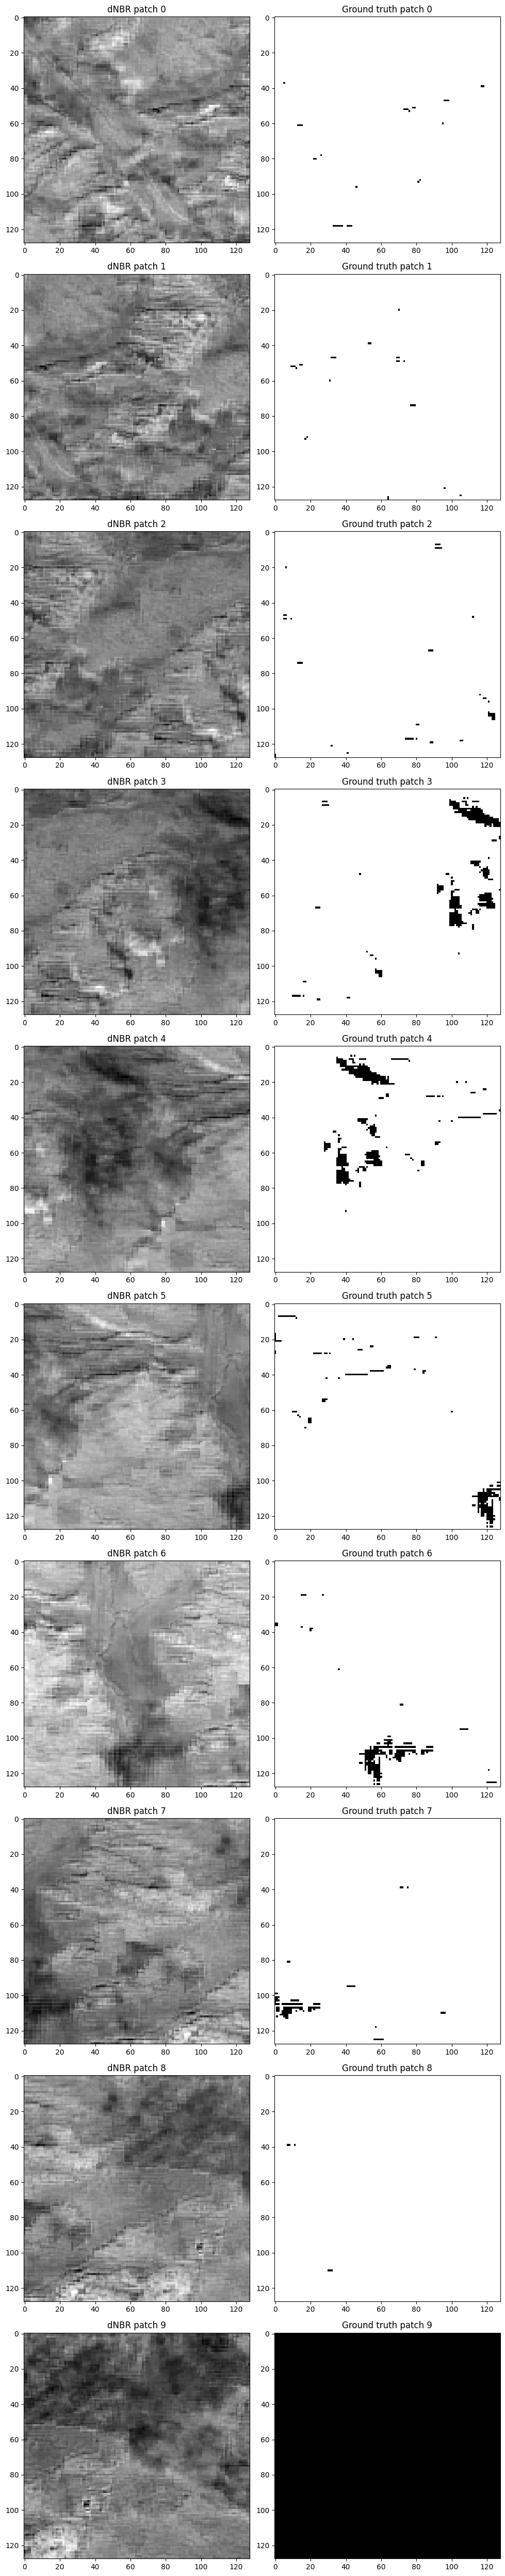

In [21]:
import matplotlib.pyplot as plt

# patches
dnbr_patches_sample = dnbr_images[:10]
ground_truth_patches_sample = ground_truth_images[:10]

fig, axes = plt.subplots(10, 2, figsize=(10, 50))

for i in range(10):
    # Show dNBR patch
    ax = axes[i, 0]
    ax.imshow(dnbr_patches_sample[i], cmap='gray')
    ax.set_title(f'dNBR patch {i}')

    # Show ground truth patch
    ax = axes[i, 1]
    ax.imshow(ground_truth_patches_sample[i], cmap='gray')
    ax.set_title(f'Ground truth patch {i}')

plt.tight_layout()
plt.show()

Minimum dNBR value: 0.0
Maximum dNBR value: 221.0


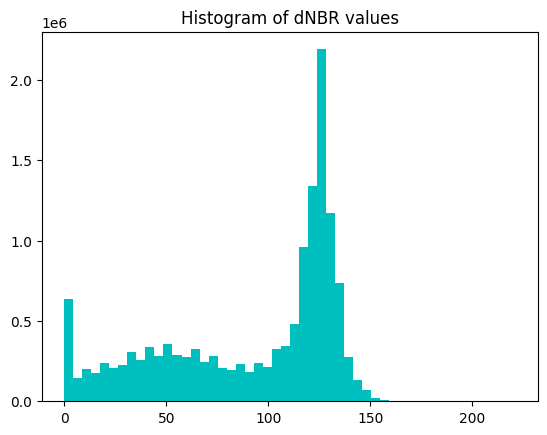

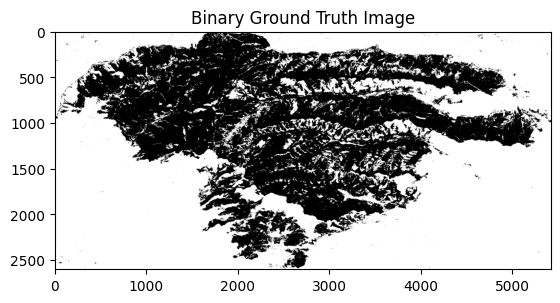

In [22]:
# Import required libraries
import numpy as np
import matplotlib.pyplot as plt
threshold = 85

dnbr_image = read_geotiff(file_path)

print("Minimum dNBR value:", np.min(dnbr_image))
print("Maximum dNBR value:", np.max(dnbr_image))

# Histo
plt.hist(dnbr_image.flatten(), bins=50, color='c')
plt.title("Histogram of dNBR values")
plt.show()

binary_ground_truth_image = (dnbr_image > threshold).astype(np.uint8)

# Vis
plt.imshow(binary_ground_truth_image, cmap='gray')
plt.title("Binary Ground Truth Image")
plt.show()

In [23]:
from ipywidgets import widgets
# Define function to update plots based on threshold value
def update(threshold):
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    #dNBR image
    ax = axes[0]
    ax.imshow(dnbr_image, cmap='gray')
    ax.set_title('dNBR Image')

#################################################################
    # ground truth
    binary_ground_truth_image = (dnbr_image > threshold).astype(np.uint8)
    ax = axes[1]
    ax.imshow(binary_ground_truth_image, cmap='gray')
    ax.set_title('Ground Truth Image')

    plt.tight_layout()
    plt.show()
##################################################################

#interactive slider
threshold_slider = widgets.FloatSlider(
    value=threshold,
    min=0,
    max=250,
    step=10,
    description='Threshold:',
    continuous_update=False
)

# Display the widget
widgets.interactive(update, threshold=threshold_slider)

interactive(children=(FloatSlider(value=85.0, continuous_update=False, description='Threshold:', max=250.0, st…

In [ ]:
def print_image_info(image_path):
    dataset = gdal.Open(image_path)
    info = gdal.Info(dataset)
    print(info)

f = "PineGulch"
image1 = f"S2/Resized_S2/TEST/resized_S2_{f}_test.tif"
image2 = f"S1/S1_Resized/resized_S1_{f}.tif"
print_image_info(image1)
print_image_info(image2)

### **CNN**

In [ ]:
from tensorflow.keras.models import load_model

#unet_model = create_unet_model()
loaded_model = load_model('/content/drive/MyDrive/Cleaned_Fire_images_TIFF/unet_model.h5')
unet_model = loaded_model

In [26]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Dropout, Input, Conv2DTranspose, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

def create_unet_model(input_shape=(128, 128, 1)):
    inputs = Input(shape=input_shape)

    # Encoder
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = BatchNormalization()(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(0.25)(p1)

    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = BatchNormalization()(c2)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(0.25)(p2)

    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = BatchNormalization()(c3)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(0.25)(p3)

    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = BatchNormalization()(c4)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(0.25)(p4)

    # Bottom
    b = Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
    b = BatchNormalization()(b)

    # Decoder
    u1 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(b)
    u1 = concatenate([u1, c4])
    u1 = Dropout(0.25)(u1)
    d1 = Conv2D(512, (3, 3), activation='relu', padding='same')(u1)
    d1 = BatchNormalization()(d1)

    u2 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(d1)
    u2 = concatenate([u2, c3])
    u2 = Dropout(0.25)(u2)
    d2 = Conv2D(256, (3, 3), activation='relu', padding='same')(u2)
    d2 = BatchNormalization()(d2)

    u3 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(d2)
    u3 = concatenate([u3, c2])
    u3 = Dropout(0.25)(u3)
    d3 = Conv2D(128, (3, 3), activation='relu', padding='same')(u3)
    d3 = BatchNormalization()(d3)

    u4 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(d3)
    u4 = concatenate([u4, c1])
    u4 = Dropout(0.25)(u4)
    d4 = Conv2D(64, (3, 3), activation='relu', padding='same')(u4)
    d4 = BatchNormalization()(d4)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(d4)

    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=Adam(), loss=BinaryCrossentropy(from_logits=False), metrics=['binary_accuracy'])
    return model

unet_model = create_unet_model()

# Train the model
X_train, X_test, y_train, y_test = train_test_split(dnbr_images, ground_truth_images, test_size=0.2)

X_train = X_train[..., np.newaxis]
X_test = X_test[..., np.newaxis]

batch_size = 32
epochs = 4
model_cnn = unet_model.fit(X_train, y_train, batch_size, epochs, validation_data=(X_test, y_test))



Epoch 1/4
81/81 [==============================] - 52s 471ms/step - loss: 0.0887 - binary_accuracy: 0.9614 - val_loss: 1.3274 - val_binary_accuracy: 0.7533
Epoch 2/4
81/81 [==============================] - 27s 338ms/step - loss: 0.0614 - binary_accuracy: 0.9751 - val_loss: 1.2954 - val_binary_accuracy: 0.8551
Epoch 3/4
81/81 [==============================] - 27s 340ms/step - loss: 0.0561 - binary_accuracy: 0.9775 - val_loss: 0.0867 - val_binary_accuracy: 0.9575
Epoch 4/4
81/81 [==============================] - 28s 343ms/step - loss: 0.0500 - binary_accuracy: 0.9795 - val_loss: 0.0221 - val_binary_accuracy: 0.9961


In [28]:
# saving and loading the model
from tensorflow.keras.models import load_model

unet_model.save('/content/drive/MyDrive/Cleaned_Fire_images_TIFF/unet_model.h5')
loaded_model = load_model('/content/drive/MyDrive/Cleaned_Fire_images_TIFF/unet_model.h5')


In [ ]:
unet_model.summary()
#tf.keras.utils.plot_model(model, "my_fashion_mnist_model.png", show_shapes=True)

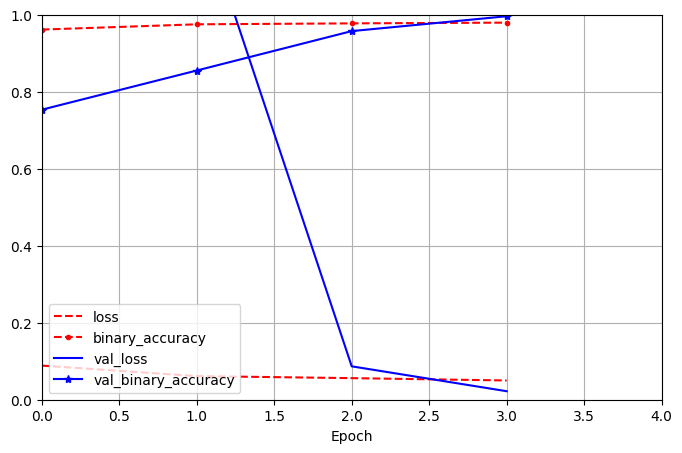

In [29]:
import matplotlib.pyplot as plt
import pandas as pd

pd.DataFrame(model_cnn.history).plot(
    figsize=(8, 5), xlim=[0, 4], ylim=[0, 1], grid=True, xlabel="Epoch",
    style=["r--", "r--.", "b-", "b-*"])
plt.legend(loc="lower left")  # extra code
#save_fig("keras_learning_curves_plot")  # extra code
plt.show()


In [ ]:
from tensorflow.keras.utils import plot_model

plot_model(unet_model, to_file='unet_model.png', show_shapes=True, show_layer_names=True)

### **ReCONSTRUCT IMAGES**

Re Construction is a little weird where I ahve to run reconstruct on the training image bafore I can do other Images.

In [30]:
def reconstruct_image_from_patches(patches, original_shape, patch_size, overlap_factor=2):
    height, width = original_shape
    reconstructed_image = np.zeros(original_shape)
    patch_count = np.zeros(original_shape)
    stride = patch_size // overlap_factor
    patch_idx = 0

    for i in range(0, height - patch_size + 1, stride):
        for j in range(0, width - patch_size + 1, stride):
            reconstructed_image[i:i+patch_size, j:j+patch_size] += patches[patch_idx]
            patch_count[i:i+patch_size, j:j+patch_size] += 1
            patch_idx += 1

    reconstructed_image /= patch_count
    return reconstructed_image

In [31]:

dnbr_images_expanded = dnbr_images[..., np.newaxis]
predictions = unet_model.predict(dnbr_images_expanded)

#Reconstruct the image from the patches
predictions = predictions[..., 0]
reconstructed_image = reconstruct_image_from_patches(predictions, dnbr_image.shape, patch_size, overlap_factor=2)


102/102 [==============================] - 8s 80ms/step


<ipython-input-30-699bb1b7c609>:14: RuntimeWarning: invalid value encountered in divide
  reconstructed_image /= patch_count


In [34]:
from PIL import Image
from skimage import exposure

def save_image_as_jpeg(image_array, output_path):
    image_array = image_array * 500
    image_uint8 = Image.fromarray(image_array.clip(0, 255).astype(np.uint8))
    image_uint8.save(output_path)

output_tif_path = 'reconstructed_image_test.tif'
output_jpeg_path = 'testUNET_7.jpeg'

#save_image_as_tif(reconstructed_image, output_tif_path, f'S1/BOX/S1_dNBR_{selected_images[0]}_box.tif')
save_image_as_jpeg(reconstructed_image, output_jpeg_path)

### **RUNNING CNN**

In [36]:
# Read and preprocess the new image
fire_name = 'CherryCanyon'
new_image_path = f'S1/BOX/S1_dNBR_{fire_name}_box.tif'
#new_image_path = f'S1/BOX/S1_sub_{fire_name}_box.tif'#
#new_image_path = f'S1/S1_Resized/resized_S1_{fire_name}.tif'
#new_image_path = f"S2/Resized_S2/TEST/resized_S2_{fire_name}_test.tif"
#new_image_path = f"S2/S2_dNBR_{fire_name}.tif"

new_image = read_geotiff(new_image_path)
preprocessed_new_image = preprocess_image(new_image)

patch_size = 128
new_image_patches = split_image_into_patches(preprocessed_new_image, patch_size, overlap_factor=2)


new_image_patches_expanded = new_image_patches[..., np.newaxis]
new_image_predictions = unet_model.predict(new_image_patches_expanded)
new_image_predictions = new_image_predictions[..., 0]


reconstructed_new_image = reconstruct_image_from_patches(new_image_predictions, new_image.shape, patch_size, overlap_factor=2)


output_tif_path = 'reconstructed_new_image_test2_GC.tif'
output_jpeg_path = f'S1_128_test_{fire_name}_UNET_2.jpeg'

#save_image_as_tif(reconstructed_new_image, output_tif_path, new_image_path)
save_image_as_jpeg(reconstructed_new_image, output_jpeg_path)

31/31 [==============================] - 2s 73ms/step


<ipython-input-30-699bb1b7c609>:14: RuntimeWarning: invalid value encountered in divide
  reconstructed_image /= patch_count


### **EVALUATIONS**

In [37]:
import pandas as pd
import cv2
from sklearn.metrics import precision_recall_fscore_support

def evaluate_image(true_image, predicted_image , threshold = 0.05):
    true_image_flattened = true_image.flatten().astype(np.float32)
    predicted_image_flattened = (predicted_image.flatten() > threshold).astype(np.float32)

    loss = BinaryCrossentropy()(true_image_flattened, predicted_image_flattened).numpy()
    accuracy = np.mean((true_image_flattened == predicted_image_flattened).astype(int))
    precision, recall, f1_score, _ = precision_recall_fscore_support(true_image_flattened, predicted_image_flattened, average='binary')

    return loss, accuracy, precision, recall, f1_score

threshold = 0.05
# Evaluate both images
fire_name_eval1 = "CherryCanyon"
fire_name_eval2 = "GrizzlyCreek"

dnbr_image1 = read_geotiff(f'S1/BOX/S1_dNBR_{fire_name_eval1}_box.tif')
dnbr_image2 = read_geotiff(f'S1/BOX/S1_dNBR_{fire_name_eval2}_box.tif')

ground_truth_image1 = (dnbr_image1 > threshold).astype(np.uint8)
ground_truth_image2 = (dnbr_image2 > threshold).astype(np.uint8)

#predicted_image1 = cv2.imread(f'CNN_predictions/S1_repatched/S1_128_test_{fire_name_eval1}_UNET.jpeg', cv2.IMREAD_GRAYSCALE)
#predicted_image2 = cv2.imread(f'CNN_predictions/S1_repatched/S1_128_2train_{fire_name_eval2}_test.jpeg', cv2.IMREAD_GRAYSCALE)

predicted_image1 = cv2.imread(f'S1_128_test_{fire_name_eval1}_UNET_2.jpeg', cv2.IMREAD_GRAYSCALE)
predicted_image2 = cv2.imread(f'S1_128_test_{fire_name_eval2}_UNET_2.jpeg', cv2.IMREAD_GRAYSCALE)

loss1, accuracy1, precision1, recall1, f1_score1 = evaluate_image(ground_truth_image1, predicted_image1)
loss2, accuracy2, precision2, recall2, f1_score2 = evaluate_image(ground_truth_image2, predicted_image2)

results_table = pd.DataFrame(
    {"Image": [fire_name_eval1, fire_name_eval2],
     "Loss": [loss1, loss2],
     "Accuracy": [accuracy1, accuracy2],
     "Precision": [precision1, precision2],
     "Recall": [recall1, recall2],
     "F1 Score": [f1_score1, f1_score2]}
)


print(results_table)

          Image      Loss  Accuracy  Precision    Recall  F1 Score
0  CherryCanyon  0.546413  0.964566   0.998189  0.965473  0.981558
1  GrizzlyCreek  0.936882  0.939196   0.986985  0.944208  0.965123


In [ ]:
def majority_class_accuracy(true_image):
    unique_elements, counts = np.unique(true_image, return_counts=True)
    majority_class_count = np.max(counts)
    return majority_class_count / np.sum(counts)

majority_class_accuracy1 = majority_class_accuracy(ground_truth_image1)
majority_class_accuracy2 = majority_class_accuracy(ground_truth_image2)

results_table["Majority Class Accuracy"] = [majority_class_accuracy1, majority_class_accuracy2]

print(results_table)


          Image      Loss  Accuracy  Precision    Recall  F1 Score  \
0  CherryCanyon  1.858866  0.879482   0.998569  0.877867  0.934336   
1  GrizzlyCreek  1.629695  0.894333   0.996982  0.884082  0.937144   

   Majority Class Accuracy  
0                 0.976714  
1                 0.891001  


### **OTHER**

Resampling
other: https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/smart_resize


In [ ]:
gdal.Info(f"/content/drive/MyDrive/Cleaned_Fire_images_TIFF/S1/BOX/S1_dNBR_{fire}_box.tif")

'Driver: GTiff/GeoTIFF\nFiles: /content/drive/MyDrive/Cleaned_Fire_images_TIFF/S1/BOX/S1_dNBR_PineGulch_box.tif\nSize is 5426, 2600\nCoordinate System is:\nGEOGCRS["WGS 84",\n    DATUM["World Geodetic System 1984",\n        ELLIPSOID["WGS 84",6378137,298.257223563,\n            LENGTHUNIT["metre",1]]],\n    PRIMEM["Greenwich",0,\n        ANGLEUNIT["degree",0.0174532925199433]],\n    CS[ellipsoidal,2],\n        AXIS["geodetic latitude (Lat)",north,\n            ORDER[1],\n            ANGLEUNIT["degree",0.0174532925199433]],\n        AXIS["geodetic longitude (Lon)",east,\n            ORDER[2],\n            ANGLEUNIT["degree",0.0174532925199433]],\n    ID["EPSG",4326]]\nData axis to CRS axis mapping: 2,1\nOrigin = (-108.779962194470457,39.526501321957831)\nPixel Size = (0.000089831528412,-0.000089831528412)\nMetadata:\n  AREA_OR_POINT=Area\nImage Structure Metadata:\n  COMPRESSION=LZW\n  INTERLEAVE=PIXEL\nCorner Coordinates:\nUpper Left  (-108.7799622,  39.5265013) (108d46\'47.86"W, 39d31

In [ ]:
gdal.Info(f"/content/drive/MyDrive/Cleaned_Fire_images_TIFF/S2/resized_S2_{fire}.tif")

'Driver: GTiff/GeoTIFF\nFiles: /content/drive/MyDrive/Cleaned_Fire_images_TIFF/S2/resized_S2_PineGulch.tif\nSize is 5426, 2600\nCoordinate System is:\nGEOGCRS["WGS 84",\n    DATUM["World Geodetic System 1984",\n        ELLIPSOID["WGS 84",6378137,298.257223563,\n            LENGTHUNIT["metre",1]]],\n    PRIMEM["Greenwich",0,\n        ANGLEUNIT["degree",0.0174532925199433]],\n    CS[ellipsoidal,2],\n        AXIS["geodetic latitude (Lat)",north,\n            ORDER[1],\n            ANGLEUNIT["degree",0.0174532925199433]],\n        AXIS["geodetic longitude (Lon)",east,\n            ORDER[2],\n            ANGLEUNIT["degree",0.0174532925199433]],\n    ID["EPSG",4326]]\nData axis to CRS axis mapping: 2,1\nOrigin = (-108.779962194470457,39.526501321957831)\nPixel Size = (0.000089831528412,-0.000089831528412)\nMetadata:\n  AREA_OR_POINT=Area\nImage Structure Metadata:\n  INTERLEAVE=BAND\nCorner Coordinates:\nUpper Left  (-108.7799622,  39.5265013) (108d46\'47.86"W, 39d31\'35.40"N)\nLower Left  (